# Stanford Cars — Training Notebook (PyTorch + timm)

This notebook downloads the Kaggle dataset `eduardo4jesus/stanford-cars-dataset` using **kagglehub**, then trains a transfer‑learning image classifier (EfficientNet) with PyTorch.

> **Tip:** If you already know the exact root folder that contains class subfolders (e.g. `.../train`), set `DATA_ROOT` directly in the **Config** cell.

## 0) Environment check

- Python ≥3.9
- GPU recommended (CUDA) but the code will fall back to CPU.

In [1]:
import sys, platform, torch
print("Python:", sys.version)
print("Platform:", platform.platform())
print("PyTorch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("CUDA device:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU only")

Python: 3.12.11 (main, Jun  4 2025, 08:56:18) [GCC 11.4.0]
Platform: Linux-6.1.123+-x86_64-with-glibc2.35
PyTorch: 2.8.0+cu126
CUDA available: True
CUDA device: Tesla T4


## 1) Install dependencies
- `kagglehub` to fetch the dataset (no Kaggle API token needed).
- `timm` for high‑quality pretrained backbones.

In [2]:
# If running locally, you may want to remove the leading '!' and run in your shell
%pip -q install kagglehub timm torch torchvision matplotlib scikit-learn --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.3/68.3 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 75.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 93.6 MB/s eta 0:00:00


## 2) Download the dataset with kagglehub
This returns the local directory where the dataset was downloaded (cached after the first run).

In [3]:
import os, pathlib, kagglehub

KAGGLE_PATH = "eduardo4jesus/stanford-cars-dataset"
dataset_dir = kagglehub.dataset_download(KAGGLE_PATH)
dataset_dir = pathlib.Path(dataset_dir)
print("Downloaded to:", dataset_dir)
print("Directory contents:")
for p in sorted(dataset_dir.iterdir()):
    print(" •", p)

100%|██████████| 1.82G/1.82G [01:20<00:00, 24.4MB/s]

Extracting files...


Downloaded to: /root/.cache/kagglehub/datasets/eduardo4jesus/stanford-cars-dataset/versions/1
Directory contents:
 • /root/.cache/kagglehub/datasets/eduardo4jesus/stanford-cars-dataset/versions/1/car_devkit
 • /root/.cache/kagglehub/datasets/eduardo4jesus/stanford-cars-dataset/versions/1/cars_test
 • /root/.cache/kagglehub/datasets/eduardo4jesus/stanford-cars-dataset/versions/1/cars_train


## 3) Auto‑detect the data root (class‑folder layout)
Many Kaggle uploads of Stanford Cars already ship as `train/<class>/*.jpg` and `test/<class>/*.jpg` or as a single folder with class subfolders.

The helper below searches for a directory whose immediate children are **mostly** subfolders each containing images — a good heuristic for `torchvision.datasets.ImageFolder`.

In [4]:
from pathlib import Path
from typing import Optional, Tuple
import imghdr

def looks_like_class_root(p: Path, min_classes: int = 10) -> bool:
    if not p.is_dir():
        return False
    subdirs = [d for d in p.iterdir() if d.is_dir()]
    if len(subdirs) < min_classes:
        return False
    # Check a few files in each subdir to see if they're images
    ok = 0
    for d in subdirs[:min(30, len(subdirs))]:
        imgs = list(d.glob("*.jpg")) + list(d.glob("*.jpeg")) + list(d.glob("*.png"))
        if imgs:
            # very light check
            ok += 1
    return ok >= max(5, min_classes // 3)

def find_class_root(base: Path) -> Optional[Path]:
    # First try common names
    for name in ["train", "training", "cars_train", "images", "data", "Stanford Cars Dataset", "stanford cars"]:
        cand = base / name
        if looks_like_class_root(cand):
            return cand
    # Walk depth‑2
    for p in base.rglob("*"):
        if p.is_dir() and looks_like_class_root(p):
            return p
    return None

candidate = find_class_root(dataset_dir)
print("Auto‑detected class root:", candidate)

/tmp/ipython-input-522195962.py:3: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


Auto‑detected class root: None


In [24]:
# 3.5 (robust) — Build processed/train & processed/val by indexing files recursively
from pathlib import Path
import numpy as np, shutil, sys, subprocess

# Ensure SciPy
try:
    import scipy.io as sio
except Exception:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "scipy"])
    import scipy.io as sio

def find_devkit(base: Path):
    for cand in [base / "car_devkit", base / "devkit", base / "CarDevKit"]:
        if cand.exists():
            return cand
    for p in base.rglob("cars_meta.mat"):
        return p.parent
    return None

def load_class_names(meta_mat: Path):
    meta = sio.loadmat(meta_mat)
    if "class_names" in meta:
        raw = meta["class_names"]
    elif "classnames" in meta:
        raw = meta["classnames"]
    else:
        raw = None
        for k, v in meta.items():
            if isinstance(v, np.ndarray) and v.dtype == "O":
                raw = v; break
        if raw is None:
            raise KeyError("Could not locate class_names in meta .mat file")
    raw = np.squeeze(raw).tolist()
    names = []
    for c in raw:
        if isinstance(c, np.ndarray):
            c = np.squeeze(c)
            try: c = c.item()
            except Exception: pass
        names.append(str(c))
    return names

def load_annos(mat_path: Path | None):
    if mat_path is None or not mat_path.exists():
        return []
    m = sio.loadmat(mat_path)
    for key in ["annotations", "annotations_test", "cars_test_annos", "cars_train_annos"]:
        if key in m:
            arr = np.squeeze(m[key])
            break
    else:
        raise KeyError(f"No annotations array in {mat_path.name}. Keys: {list(m.keys())}")
    ann = []
    for i in range(arr.shape[0]):
        rec = arr[i]
        d = {}
        for name in rec.dtype.names:
            val = rec[name]
            if name == "fname":
                v = val
                while isinstance(v, np.ndarray):
                    v = np.squeeze(v)
                    if v.shape == ():
                        v = v.item()
                        break
                d["fname"] = str(v)
            elif name == "class":
                d["class"] = int(np.squeeze(val))
            else:
                try: d[name] = int(np.squeeze(val))
                except Exception: d[name] = val
        ann.append(d)
    return ann

def safe_link_or_copy(src: Path, dst: Path):
    dst.parent.mkdir(parents=True, exist_ok=True)
    try:
        dst.symlink_to(src.resolve())
    except Exception:
        shutil.copy2(src, dst)

# -- paths
cars_train = dataset_dir / "cars_train"
cars_test  = dataset_dir / "cars_test"
devkit     = find_devkit(dataset_dir)
assert cars_train.exists(), f"Missing {cars_train}"
assert devkit is not None and devkit.exists(), f"Could not find devkit under {dataset_dir}"

meta_mat  = next(devkit.rglob("cars_meta.mat"))
# train/test annos (test with labels may not exist)
train_mat = next(devkit.rglob("cars_train_annos*.mat"))
test_mats = list(devkit.rglob("cars_test_annos_withlabels*.mat"))
test_mat  = test_mats[0] if test_mats else None

class_names = load_class_names(meta_mat)
print("Detected classes:", len(class_names))

# Build filename index for robust matching (recursive, case-insensitive)
def build_index(root: Path):
    index = {}
    total = 0
    for ext in ("*.jpg","*.jpeg","*.png","*.JPG","*.JPEG","*.PNG"):
        for p in root.rglob(ext):
            index[p.name.lower()] = p
            total += 1
    return index, total

train_index, n_train_files = build_index(cars_train)
test_index,  n_test_files  = build_index(cars_test)
print(f"Indexed {n_train_files} train files and {n_test_files} test files.")

# Load annotations
train_ann = load_annos(train_mat)
test_ann  = load_annos(test_mat) if test_mat else []

# Outputs
processed = dataset_dir / "processed"
train_out = processed / "train"
val_out   = processed / "val"
train_out.mkdir(parents=True, exist_ok=True)
val_out.mkdir(parents=True, exist_ok=True)

# Split 80/20 by class from *train* annotations
from collections import defaultdict
by_class = defaultdict(list)
for a in train_ann:
    by_class[a["class"]].append(a)

rng = np.random.default_rng(42)
moved = 0
missing = 0

for cls_id, items in by_class.items():
    cls_name = class_names[cls_id - 1]
    rng.shuffle(items)
    k = max(1, int(0.2 * len(items)))
    val_items   = items[:k]
    train_items = items[k:]

    for a in train_items + val_items:
        fname = Path(a["fname"]).name.lower()   # match by basename
        src = train_index.get(fname)
        if src is None:
            missing += 1
            continue
        dst_root = val_out if a in val_items else train_out
        dst = dst_root / cls_name / src.name
        safe_link_or_copy(src, dst)
        moved += 1

# Optionally add labeled test to validation
added_test = 0
for a in test_ann:
    fname = Path(a["fname"]).name.lower()
    src = test_index.get(fname)
    if src is None:
        continue
    cls_name = class_names[a["class"] - 1]
    dst = val_out / cls_name / src.name
    safe_link_or_copy(src, dst)
    added_test += 1

print(f"Placed {moved} images into {processed} (symlinked where possible).")
print(f"Added {added_test} labeled test images to validation.")
print(f"Missing from index: {missing}")

# Final check
print("Processed roots ready:", train_out, "|", val_out,
      "| train exists:", train_out.exists(), "val exists:", val_out.exists())


Detected classes: 196
Indexed 8144 train files and 8041 test files.
Placed 8144 images into /root/.cache/kagglehub/datasets/eduardo4jesus/stanford-cars-dataset/versions/1/processed (symlinked where possible).
Added 0 labeled test images to validation.
Missing from index: 0
Processed roots ready: /root/.cache/kagglehub/datasets/eduardo4jesus/stanford-cars-dataset/versions/1/processed/train | /root/.cache/kagglehub/datasets/eduardo4jesus/stanford-cars-dataset/versions/1/processed/val | train exists: True val exists: True


## 4) Config

If `candidate` above is `None` or not what you expect, set `DATA_ROOT` manually to the folder that contains **class subfolders**.

In [25]:
from pathlib import Path

DATA_ROOT = dataset_dir / "processed" / "train"
VAL_ROOT  = dataset_dir / "processed" / "val"

assert DATA_ROOT.exists(), f"DATA_ROOT does not exist: {DATA_ROOT}"
assert VAL_ROOT.exists(), f"VAL_ROOT does not exist: {VAL_ROOT}"

print("Using training root:", DATA_ROOT)
print("Using validation root:", VAL_ROOT)

Using training root: /root/.cache/kagglehub/datasets/eduardo4jesus/stanford-cars-dataset/versions/1/processed/train
Using validation root: /root/.cache/kagglehub/datasets/eduardo4jesus/stanford-cars-dataset/versions/1/processed/val


## 5) Dataset & Dataloaders

We’ll use `ImageFolder`, create a **train/val split** (80/20), and apply standard augmentations.

In [26]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

IMG_SIZE = 224
train_tfms = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.7, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

val_tfms = transforms.Compose([
    transforms.Resize(int(IMG_SIZE*1.15)),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

train_ds = datasets.ImageFolder(str(DATA_ROOT), transform=train_tfms)
val_ds   = datasets.ImageFolder(str(VAL_ROOT),  transform=val_tfms)

n_classes = len(train_ds.classes)
print("Classes:", n_classes)
print("Example classes:", train_ds.classes[:10])

BATCH_SIZE = 32
NUM_WORKERS = 2  # bump on Colab/desktop Linux if you like
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=NUM_WORKERS, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)


Classes: 196
Example classes: ['AM General Hummer SUV 2000', 'Acura Integra Type R 2001', 'Acura RL Sedan 2012', 'Acura TL Sedan 2012', 'Acura TL Type-S 2008', 'Acura TSX Sedan 2012', 'Acura ZDX Hatchback 2012', 'Aston Martin V8 Vantage Convertible 2012', 'Aston Martin V8 Vantage Coupe 2012', 'Aston Martin Virage Convertible 2012']


## 6) Build the model (timm EfficientNet)

We replace the classifier head to match `n_classes` and train with AdamW + cosine schedule. Mixed precision is used when CUDA is available.

In [27]:
import timm, torch, torch.nn as nn
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = timm.create_model("efficientnet_b0", pretrained=True, num_classes=n_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
scheduler = CosineAnnealingLR(optimizer, T_max=10)
scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())

def accuracy(logits, y):
    preds = logits.argmax(dim=1)
    return (preds == y).float().mean().item()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

/tmp/ipython-input-1248361268.py:13: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())


## 7) Train loop with early stopping
Saves the **best** checkpoint to `./checkpoints/best_model.pt`.

In [30]:
import os, math, time, numpy as np, torch
from pathlib import Path

ckpt_dir = Path("./checkpoints")
ckpt_dir.mkdir(parents=True, exist_ok=True)
best_path = ckpt_dir / "best_model.pt"

EPOCHS = 10
patience = 3
best_val = -1.0
stale = 0

for epoch in range(1, EPOCHS+1):
    model.train()
    total_loss = 0.0
    total_acc = 0.0
    n_batches = 0
    start = time.time()
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
            logits = model(x)
            loss = criterion(logits, y)
        scaler.scale(loss).asynchronous().backward() if hasattr(scaler, "asynchronous") else scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()

        total_loss += loss.item()
        total_acc  += accuracy(logits.detach(), y)
        n_batches  += 1

    train_loss = total_loss / max(1, n_batches)
    train_acc  = total_acc / max(1, n_batches)

    # Validation
    model.eval()
    val_acc = 0.0
    val_batches = 0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            val_acc += accuracy(logits, y)
            val_batches += 1

    val_acc /= max(1, val_batches)

    elapsed = time.time() - start
    print(f"Epoch {epoch:02d}/{EPOCHS} | train_loss={train_loss:.4f} train_acc={train_acc:.4f} val_acc={val_acc:.4f} | {elapsed:.1f}s")

    # Early stopping on val_acc
    if val_acc > best_val:
        best_val = val_acc
        stale = 0
        torch.save({"model": model.state_dict(), "classes": datasets.ImageFolder(root=str(DATA_ROOT)).classes}, best_path)
        print("  ✓ Saved new best:", best_path)
    else:
        stale += 1
        if stale >= patience:
            print("Early stopping.")
            break

/tmp/ipython-input-1752825357.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


Epoch 01/10 | train_loss=4.9010 train_acc=0.0577 val_acc=0.1939 | 84.3s
  ✓ Saved new best: checkpoints/best_model.pt
Epoch 02/10 | train_loss=2.9260 train_acc=0.4306 val_acc=0.4416 | 64.4s
  ✓ Saved new best: checkpoints/best_model.pt
Epoch 03/10 | train_loss=1.4596 train_acc=0.7319 val_acc=0.5812 | 64.4s
  ✓ Saved new best: checkpoints/best_model.pt
Epoch 04/10 | train_loss=0.7395 train_acc=0.8723 val_acc=0.6440 | 62.8s
  ✓ Saved new best: checkpoints/best_model.pt
Epoch 05/10 | train_loss=0.3957 train_acc=0.9395 val_acc=0.6724 | 62.6s
  ✓ Saved new best: checkpoints/best_model.pt
Epoch 06/10 | train_loss=0.2306 train_acc=0.9697 val_acc=0.6809 | 64.0s
  ✓ Saved new best: checkpoints/best_model.pt
Epoch 07/10 | train_loss=0.1449 train_acc=0.9824 val_acc=0.7024 | 62.7s
  ✓ Saved new best: checkpoints/best_model.pt
Epoch 08/10 | train_loss=0.0940 train_acc=0.9918 val_acc=0.7145 | 62.6s
  ✓ Saved new best: checkpoints/best_model.pt
Epoch 09/10 | train_loss=0.0734 train_acc=0.9915 val_acc

## 8) Evaluate and visualize confusion matrix

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


                                                        precision    recall  f1-score   support

                            AM General Hummer SUV 2000       0.75      1.00      0.86         9
                             Acura Integra Type R 2001       0.64      0.78      0.70         9
                                   Acura RL Sedan 2012       1.00      0.17      0.29         6
                                   Acura TL Sedan 2012       0.88      0.88      0.88         8
                                  Acura TL Type-S 2008       0.67      0.75      0.71         8
                                  Acura TSX Sedan 2012       0.71      0.62      0.67         8
                              Acura ZDX Hatchback 2012       1.00      0.86      0.92         7
              Aston Martin V8 Vantage Convertible 2012       0.17      0.11      0.13         9
                    Aston Martin V8 Vantage Coupe 2012       0.44      0.50      0.47         8
                  Aston Martin Virage C

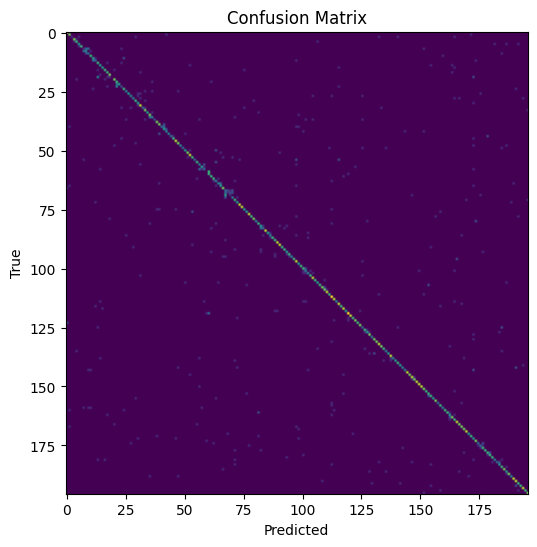

In [31]:
import torch, matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Load best
ckpt = torch.load(best_path, map_location=device)
model.load_state_dict(ckpt["model"])
classes = ckpt["classes"]

# Collect predictions
y_true, y_pred = [], []
model.eval()
with torch.no_grad():
    for x, y in val_loader:
        x = x.to(device)
        logits = model(x)
        preds = logits.argmax(dim=1).cpu().numpy()
        y_pred.extend(preds.tolist())
        y_true.extend(y.numpy().tolist())

print(classification_report(y_true, y_pred, target_names=[str(c) for c in classes][:len(set(y_true))]))

cm = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots(figsize=(6,6))
ax.imshow(cm)  # No specific colors set (policy requirement)
ax.set_title("Confusion Matrix")
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
plt.show()

In [34]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


## 9) Inference helper

Pass the path to a local image; the function returns the predicted class label.

In [49]:
from PIL import Image
import torch
from torchvision import transforms

infer_tfms = transforms.Compose([
    transforms.Resize(int(224*1.15)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

def predict_image(path: str):
    img = Image.open(path).convert("RGB")
    x = infer_tfms(img).unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad():
        logits = model(x)
        pred = logits.argmax(dim=1).item()
    return classes[pred]

predict_image("/content/drive/MyDrive/toyota.jpg")

'Volkswagen Golf Hatchback 1991'

In [50]:
import io, requests, torch
from PIL import Image
from torchvision import transforms

IMG_SIZE = 300 if '300' in str(next(model.parameters()).shape) else 224  # adjust if you switched models

infer_tfms = transforms.Compose([
    transforms.Resize(int(IMG_SIZE*1.15)),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225)),
])

def load_image_from_url(url: str) -> Image.Image:
    r = requests.get(url, timeout=20)
    r.raise_for_status()
    return Image.open(io.BytesIO(r.content)).convert("RGB")

@torch.no_grad()
def topk_preds(img: Image.Image, k=5):
    x = infer_tfms(img).unsqueeze(0).to(device)
    logits = model(x)
    probs = logits.softmax(1).squeeze(0)
    topk = torch.topk(probs, k)
    ids = topk.indices.cpu().tolist()
    ps  = topk.values.cpu().tolist()
    return [(classes[i], float(p)) for i,p in zip(ids, ps)]

img = img = Image.open("/content/drive/MyDrive/toyota.jpg").convert("RGB")
for name, p in topk_preds(img, k=5):
    print(f"{name:60s}  {p:.3f}")

Volkswagen Golf Hatchback 1991                                0.446
Audi 100 Sedan 1994                                           0.252
Nissan 240SX Coupe 1998                                       0.097
Audi 100 Wagon 1994                                           0.043
Plymouth Neon Coupe 1999                                      0.025


## 10) Export the model

Saves a TorchScript file (`best_model.ts`) for easier deployment.

In [47]:
example = torch.randn(1, 3, 224, 224, device=device)
traced = torch.jit.trace(model, example)
ts_path = "./checkpoints/best_model.ts"
traced.save(ts_path)
print("Saved TorchScript to:", ts_path)

Saved TorchScript to: ./checkpoints/best_model.ts


## Notes & Troubleshooting

- If auto‑detection of the data root fails, manually set `DATA_ROOT` to the folder that contains **one subfolder per class**.
- Some Kaggle mirrors of Stanford Cars include a devkit with `.mat` annotation files instead of class folders. In that case, consider preprocessing into a class‑folder layout or adapting the dataset loader.
- For faster training, try `efficientnet_b1`/`b2` with larger image sizes and adjust the batch size.

## 11) Save the notebook & checkpoints to **Google Drive**

Pick **either** Option A (easy if you're on Colab) **or** Option B (works on any Jupyter with OAuth in your browser).

### Option A — Colab: mount Drive and copy files

In [ ]:
# If you're running this in Google Colab:
try:
    from google.colab import drive
    drive.mount('/content/drive')
    print("Mounted at /content/drive")
except Exception as e:
    print("Not on Colab or google.colab not available:", e)

In [48]:
# Paths
import os, shutil, pathlib, glob

# Where this notebook saved artifacts earlier
LOCAL_NOTEBOOK = "StanfordCars_Training.ipynb"   # this current file name
LOCAL_DIR      = os.getcwd()                     # current working dir
CKPT_DIR       = os.path.join(LOCAL_DIR, "checkpoints")

# Where to put them in Drive
DRIVE_DIR = "/content/drive/MyDrive/StanfordCars"  # change if you want

# Ensure Drive target exists
pathlib.Path(DRIVE_DIR).mkdir(parents=True, exist_ok=True)

# Copy notebook itself (if present) and checkpoints
if os.path.exists(LOCAL_NOTEBOOK):
    shutil.copy2(LOCAL_NOTEBOOK, DRIVE_DIR)
    print("Copied:", LOCAL_NOTEBOOK, "->", DRIVE_DIR)
else:
    print("Notebook file not found in CWD; if running as .ipynb, this is expected.")

if os.path.isdir(CKPT_DIR):
    for p in glob.glob(os.path.join(CKPT_DIR, "*")):
        shutil.copy2(p, DRIVE_DIR)
        print("Copied:", p, "->", DRIVE_DIR)
else:
    print("No checkpoints directory found (yet).")

Notebook file not found in CWD; if running as .ipynb, this is expected.
Copied: /content/checkpoints/best_model.ts -> /content/drive/MyDrive/StanfordCars
Copied: /content/checkpoints/best_model.pt -> /content/drive/MyDrive/StanfordCars


### Option B — Any Jupyter: upload via PyDrive2 (OAuth)
You can upload the generated files to a specific Drive **folder** by ID. If you don't know the folder ID, create a folder in Drive, open it in your browser, and copy the long ID from the URL.

In [ ]:
%pip -q install pydrive2 --upgrade

In [ ]:
from pydrive2.auth import GoogleAuth
from pydrive2.drive import GoogleDrive
import os, glob

# OAuth in a browser window the first time:
gauth = GoogleAuth()
gauth.LocalWebserverAuth()  # follow the link & paste code if needed
drive = GoogleDrive(gauth)

FOLDER_ID = ""  # <-- Optional: put your Drive folder ID here (or leave blank to upload to root)

def upload_file(path, folder_id=None):
    fname = os.path.basename(path)
    metadata = {"title": fname}
    if folder_id:
        metadata["parents"] = [{"id": folder_id}]
    f = drive.CreateFile(metadata)
    f.SetContentFile(path)
    f.Upload()
    print("Uploaded:", fname, "id:", f["id"])
    return f["id"]

# Upload checkpoints and (optionally) the notebook file saved to disk
targets = []
if os.path.isdir("checkpoints"):
    targets.extend(glob.glob("checkpoints/*"))
if os.path.exists("StanfordCars_Training.ipynb"):
    targets.append("StanfordCars_Training.ipynb")

if not targets:
    print("Nothing to upload yet. Train first to create checkpoints or ensure paths are correct.")
else:
    for t in targets:
        upload_file(t, FOLDER_ID or None)

In [53]:
# Multi-image (3 views) -> single prediction
# - mode="logit_mean": average logits (robust default)
# - mode="softmax_mean": average probabilities
# - mode="conf_weighted": confidence-weighted avg (lower entropy = higher weight)
# - make_rerank=True: pick the most likely MAKE first, then top classes within that make

# If you don't have requests installed (for URLs):  %pip -q install requests

import io, requests, torch
from PIL import Image
from torchvision import transforms

# Use your existing infer_tfms; if missing, define a safe default:
try:
    infer_tfms
except NameError:
    IMG_SIZE = 224
    infer_tfms = transforms.Compose([
        transforms.Resize(int(IMG_SIZE*1.15)),
        transforms.CenterCrop(IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225)),
    ])

def _load_image(item):
    if isinstance(item, Image.Image):
        return item.convert("RGB")
    if isinstance(item, str) and item.startswith(("http://","https://")):
        r = requests.get(item, timeout=20)
        r.raise_for_status()
        return Image.open(io.BytesIO(r.content)).convert("RGB")
    return Image.open(item).convert("RGB")

@torch.no_grad()
def _logits_for(img):
    x = infer_tfms(img).unsqueeze(0).to(device)
    return model(x)  # [1, C]

@torch.no_grad()
def predict_from_images(items, mode="logit_mean", topk=5, make_rerank=True):
    # items: list of 3 paths/URLs/PIL Images
    logits_list = []
    for it in items:
        img = _load_image(it)
        logits = _logits_for(img).squeeze(0)  # [C]
        logits_list.append(logits)

    L = torch.stack(logits_list, dim=0)  # [N, C]

    if mode == "softmax_mean":
        probs = torch.softmax(L, dim=1).mean(dim=0)
    elif mode == "conf_weighted":
        probs_i = torch.softmax(L, dim=1)            # [N, C]
        ent = (-probs_i * (probs_i.clamp_min(1e-9)).log()).sum(dim=1)  # [N] entropy
        w = 1.0 / (ent + 1e-6)
        w = w / w.sum()
        probs = (probs_i * w[:, None]).sum(dim=0)    # weighted mean of probs
    else:  # "logit_mean" (default): softmax(mean logits)
        probs = torch.softmax(L.mean(dim=0), dim=0)

    # Top-K overall
    vals, idx = probs.topk(topk)
    idx = idx.cpu().tolist()
    vals = vals.cpu().tolist()
    overall_topk = [(classes[i], float(p)) for i, p in zip(idx, vals)]

    if not make_rerank:
        return {"mode": mode, "topk": overall_topk}

    # Make-aware re-ranking
    from collections import defaultdict
    make_to_ids = defaultdict(list)
    for i, name in enumerate(classes):
        mk = name.split()[0]
        make_to_ids[mk].append(i)

    probs_np = probs.cpu().numpy()
    make_scores = {mk: float(probs_np[ids].sum()) for mk, ids in make_to_ids.items()}
    best_make = max(make_scores, key=make_scores.get)

    ids = make_to_ids[best_make]
    ids_sorted = sorted(ids, key=lambda i: probs_np[i], reverse=True)
    make_topk = [(classes[i], float(probs_np[i])) for i in ids_sorted[:topk]]

    return {
        "mode": mode,
        "topk": overall_topk,
        "best_make": best_make,
        "make_topk": make_topk
    }

In [63]:
items = [
    "/content/drive/MyDrive/audi.webp",
    "/content/drive/MyDrive/audi2.webp",
    "/content/drive/MyDrive/audi3.webp",
    # URLs also work:
    # "https://example.com/car1.jpg",
]

out = predict_from_images(items, mode="logit_mean", topk=5, make_rerank=True)
print("Overall Top-3:", out["topk"][:3])
print("Best make:", out["best_make"])
print("Within-make Top-3:", out["make_topk"][:3])

Overall Top-3: [('Audi S4 Sedan 2012', 0.3958580791950226), ('Audi R8 Coupe 2012', 0.10486044734716415), ('Audi A5 Coupe 2012', 0.10164438188076019)]
Best make: Audi
Within-make Top-3: [('Audi S4 Sedan 2012', 0.3958580791950226), ('Audi R8 Coupe 2012', 0.10486044734716415), ('Audi A5 Coupe 2012', 0.10164438188076019)]
